<a href="https://colab.research.google.com/github/Tim-Mortier/Database-editor/blob/main/topic10/HFST10_LSTM_intro_no_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

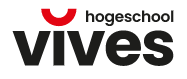<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# Deep learning for timeseries: a gentle introduction

Een **tijdreeks** - time series in het Engels - bestaat uit data verkregen via observaties of metingen die op regelmatige tijdsintervallen zijn genomen. De belangrijkste machine learning taak in dat verband is het vervolg van een tijdreeks voorspellen. Dat noemt men **forecasting**.

In dit topic zullen we **Recurrente Neurale Netwerken** (RNNs) bespreken en leren hoe je die toepast bij forecasting. Maar vooraleer we hoofdstuk 10 van het boek "Deep Learning with Python" (2e editie) van François Chollet doornemen, gaan we eerst enkele technieken uitleggen adhv zeer eenvoudige voorbeelden. We zullen hierin simpele **Long Short-Term Memory** (LSTM) modellen toepassen, een populaire soort van RNNs.

## Hoe werken RNN en LSTM?

In hoofdstuk 10 van het boek "Deep Learning with Python" wordt uitgelegd hoe RNN en LSTM modellen zijn opgebouwd. Om nu toch al enig idee te krijgen hoe ze werken, bekijken we de volgende YouTube filmpjes van StatQuest (in deze volgorde!):

1. *Recurrent Neural Networks* (RNNs), Clearly Explained: https://youtu.be/AsNTP8Kwu80
2. *Long Short-Term Memory* (LSTM), Clearly Explained: https://youtu.be/YCzL96nL7j0

### RNN

Hieronder wordt het voorbeeldje van de eerste video over RNN geïmplementeerd.

In [87]:
import numpy as np
import matplotlib.pyplot as plt

Dit zijn de vier tijdreeksen:

In [88]:
X = np.array([[0.0, 0.0, 0.0],
              [0.0, 0.5, 1.0],
              [1.0, 0.5, 0.0],
              [1.0, 1.0, 1.0]])

De plots van die tijdreeksen:

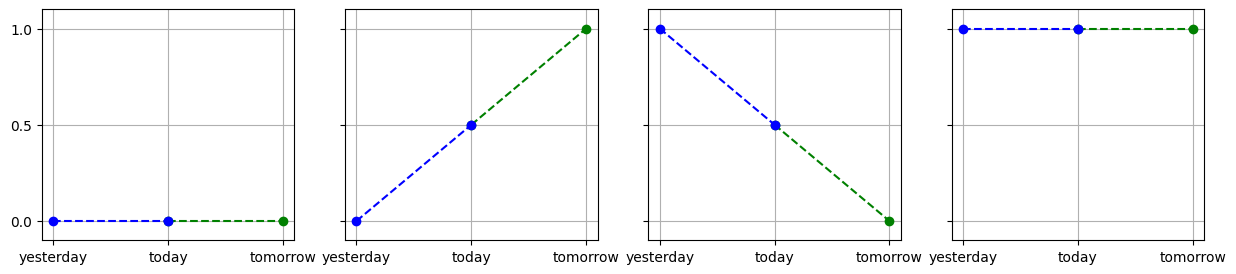

In [89]:
_, axes = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.plot([1, 2], X[i, -2:], 'go--');
    ax.plot([0, 1], X[i, :-1], 'bo--');
    ax.grid();
    ax.set_ylim((-0.1, 1.1));
    ax.set_yticks([0.0, 0.5, 1.0]);
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['yesterday', 'today', 'tomorrow']);

Dit is de functie `RNN` die het eenvoudige neurale netwerk één keer "ontvouwt":

In [90]:
def RNN(X, w, b, activation):
    node = lambda x: activation(x * w[0] + b[0])
    y1 = node(X[:, 0])
    y2 = node(X[:, 1]) + w[1] * y1
    return y2 * w[-1] + b[-1]

De functie toepassen op de tijdreeksen met de gegeven parameters en `relu` als activatiefunctie:

In [91]:
relu = lambda x: np.maximum(x, 0.0)  # maximum ipv max!
w = [1.8, -0.5, 1.1]
b = [0.0, 0.0]

RNN(X[:, :-1], w, b, relu)

array([0.  , 0.99, 0.  , 0.99])

We kunnen functie `RNN` generiek schrijven voor `n` keren "ontvouwen":

In [92]:
def RNN(X, w, b, activation):
    node = lambda x: activation(x * w[0] + b[0])
    n = X.shape[-1]  # number of times node must be unfolded
    y = 0.0
    for i in range(n):
        y = node(X[:, i]) + w[1] * y
    return y * w[-1] + b[-1]

Uittesten op de dataset:

In [93]:
RNN(X[:, :-1], w, b, relu)

array([0.  , 0.99, 0.  , 0.99])

Definiëren we nu een reeks met 4 tijdstippen ipv 3:

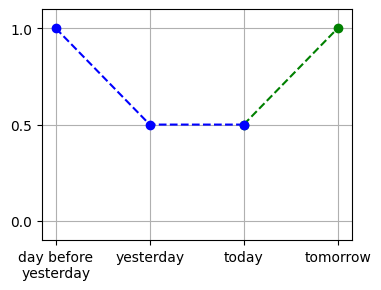

In [94]:
X2 = np.array([[1.0, 0.5, 0.5, 1.0]])

_, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot([2, 3], X2[0, -2:], 'go--');
ax.plot([0, 1, 2], X2[0, :-1], 'bo--');
ax.grid();
ax.set_ylim((-0.1, 1.1));
ax.set_yticks([0.0, 0.5, 1.0]);
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['day before\nyesterday', 'yesterday', 'today', 'tomorrow']);

Van deze reeks kunnen we nu ook de forecast berekenen:

In [95]:
RNN(X2[:, :-1], w, b, relu)

array([0.99])

Zoals in de video wordt uitgelegd heeft dit type netwerk vaak problemen met **vanishing gradients** of **exploding gradients**. Een oplossing hiervoor is de LSTM.

### LSTM

Hieronder volgt de code van het voorbeeldje uit de tweede video over LSTM.

Eerst en vooral wordt uitgelegd hoe een LSTM eenheid inwendig gebruik maakt van de [sigmoïdefunctie](https://nl.wikipedia.org/wiki/Sigmo%C3%AFdefunctie) en de [tangenshyperbolicus functie](https://nl.wikipedia.org/wiki/Hyperbolische_functie). De definities van die functies zijn:

> $σ(x) = \frac{e^x}{e^x+1}$

> $\tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}$

Laten we die functies eens plotten:

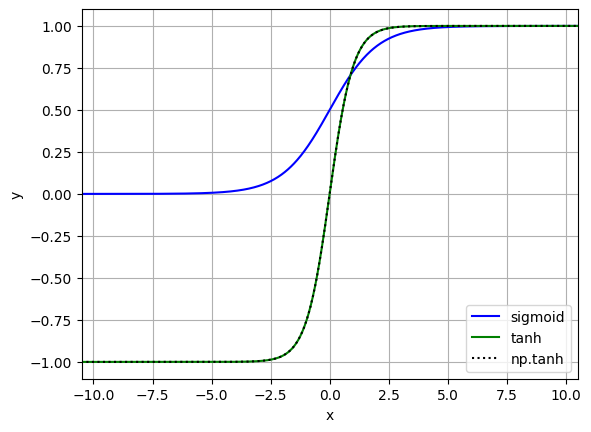

In [96]:
sigmoid = lambda x: np.exp(x) / (np.exp(x) + 1)
tanh = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

x = np.linspace(-11, 11, 1000)
plt.plot(x, sigmoid(x), 'b-', label="sigmoid");
plt.plot(x, tanh(x), 'g-', label="tanh");
plt.plot(x, np.tanh(x), 'k:', label="np.tanh");  # ingebouwde numpy tanh
plt.grid();
plt.xlabel('x');
plt.xlim((-10.5, 10.5))
plt.ylabel('y');
plt.legend(loc="lower right");

We zien dat een x-waarde wordt afbeeld op een getal tussen:

- 0 en 1 door de sigmoïdefunctie;
- -1 en 1 door de tanh functie.

Dit zijn de berekeningen van het eerste voorbeeldje uit de video dat uitvoerig uitlegt hoe een LSTM unit werkt. Deze eenheid updatet de long-term en de short-term memory. En dat gebeurt in 3 stappen, ook wel "gates" genoemd:

- forget gate
- input gate
- output gate

In [97]:
# inputs
x = 1  # input
LTM = 2  # long-term memory
STM = 1  # short-term memory

# stage 1 (forget gate - % LTM to remember)
wSTM1 = 2.70
w1 = 1.63
b1 = 1.62
pLTM = sigmoid(wSTM1 * STM + w1 * x + b1)  # % long-term memory
print("% long-term memory to remember:", pLTM)
out1 = pLTM * LTM
print("long-term memory to remember:", out1)

# stage 2a (input gate - % potential memory to remember)
wSTM2 = 2.00
w2 = 1.65
b2 = 0.62
pPLTM = sigmoid(wSTM2 * STM + w2 * x + b2)  # % potential long-term memory
print("% potential long-term memory to remember:", pPLTM)

# stage 2b (input gate - potential LTM)
wSTM3 = 1.41
w3 = 0.94
b3 = -0.32
PLTM = tanh(wSTM3 * STM + w3 * x + b3)  # potential long-term memory
out2 = pPLTM * PLTM
print("potential long-term memory:", out2)
newLTM = out1 + out2  # new long-term memory
print("new long-term memory:", newLTM)

# final stage (output gate)
PSTM = tanh(newLTM)  # potential short-term memory
wSTM4 = 4.38
w4 = -0.19
b4 = 0.59
pPSTM = sigmoid(wSTM4 * STM + w4 * x + b4)  # % potential short-term memory
print("% potential short-term memory to remember:", pPSTM)
newSTM = pPSTM * PSTM  # new short-term memory
print("new short-term memory:", newSTM)

% long-term memory to remember: 0.9974009322376767
long-term memory to remember: 1.9948018644753533
% potential long-term memory to remember: 0.9862110114938585
potential long-term memory: 0.9527655674199651
new long-term memory: 2.9475674318953184
% potential short-term memory to remember: 0.9916739069015662
new short-term memory: 0.9862291254174955


De resultaten die wij hier bekomen verschillen een beetje van die uit de video, maar dat is omdat men in de video de waarden afrondt op 2 cijfers na de komma. We stoppen nu die code in een functie `LSTMunit`:

In [98]:
def LSTMunit(x, LTM, STM, wSTM, w, b):
    # forget gate
    pLTM = sigmoid(wSTM[0] * STM + w[0] * x + b[0])  # % long-term memory
    out1 = pLTM * LTM
    # input gate
    pPLTM = sigmoid(wSTM[1] * STM + w[1] * x + b[1])  # % potential long-term memory
    PLTM = tanh(wSTM[2] * STM + w[2] * x + b[2])  # potential long-term memory
    out2 = pPLTM * PLTM
    newLTM = out1 + out2  # new long-term memory
    # output gate
    PSTM = tanh(newLTM)  # potential short-term memory
    pPSTM = sigmoid(wSTM[3] * STM + w[3] * x + b[3])  # % potential short-term memory
    newSTM = pPSTM * PSTM  # new short-term memory
    return newLTM, newSTM

We testen de functie met de waarden van het eerste voorbeeldje:

In [99]:
# inputs
x = 1  # input
LTM = 2  # long-term memory
STM = 1  # short-term memory

# parameters
wSTM = [2.70, 2.00, 1.41, 4.38]
w = [1.63, 1.65, 0.94, -0.19]
b = [1.62, 0.62, -0.32, 0.59]

LSTMunit(x, LTM, STM, wSTM, w, b)

(2.9475674318953184, 0.9862291254174955)

We krijgen exact hetzelfde resultaat! Laten we net als in het filmpje ook nog eens de waarde -10 als input nemen:

In [100]:
x = -10
LSTMunit(x, LTM, STM, wSTM, w, b)

(1.1599043748745436e-05, 1.158701090312709e-05)

In het tweede voorbeeldje in de video wordt de waarde op dag 5 voorspelt van twee reeksen met metingen van 5 dagen:

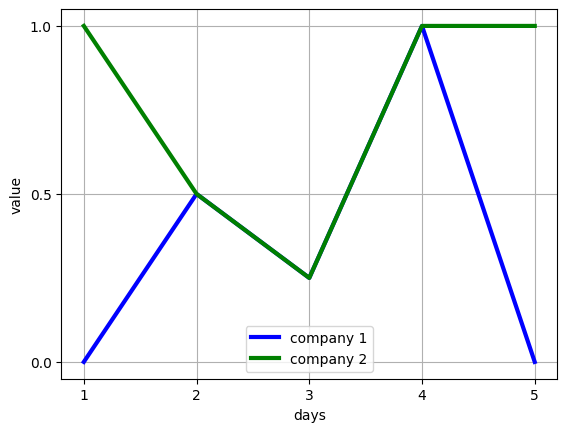

In [101]:
X = np.array([[0, 0.5, 0.25, 1, 0],
              [1, 0.5, 0.25, 1, 1]])
days = np.arange(1, X.shape[-1] + 1)
plt.plot(days, X[0, :], 'b-', linewidth=3, label="company 1");
plt.plot(days, X[1, :], 'g-', linewidth=3, label="company 2");
plt.xticks(days);
plt.yticks([0, 0.5, 1]);
plt.grid();
plt.xlabel("days");
plt.ylabel("value");
plt.legend();

Om de waarde op dag 5 te voorspellen, moeten we de data van de 4 vorige dagen doorlopen. D.w.z. dat we de LSTM eenheid 4 keer moeten toepassen. We schrijven hiervoor een generieke functie `LSTM`:

In [102]:
def LSTM(X, wSTM, w, b):
    LTM, STM = 0, 0
    for i in range(len(X)):
        LTM, STM = LSTMunit(X[i], LTM, STM, wSTM, w, b)
    return STM

Als we die functie nu toepassen op onze 2 reeksen, dan zien we dat de voorspelling inderdaad dicht bij 0 ligt voor de eerste tijdreeks, en dicht bij 1 voor de tweede reeks, ook al verschillen de reeksen enkel op dag 1. Dat betekent dat `LSTM` inderdaad in staat is om de waarde van dag 1 te 'onthouden'!

In [103]:
for i in range(len(X)):
    print(LSTM(X[i, :-1], wSTM, w, b))

0.00639315824080562
0.969393461640768


## Een eenvoudig voorbeeldje

RNN en LTSM zijn uiteraard ook beschikbaar in Keras. In deze sectie passen we enkele simpele LSTM modellen toe mbv Keras. We passen die modellen toe op een zeer eenvoudige univariate en multivariate tijdreeks.

### Univariate tijdreeks

Om te illustreren hoe we een neuraal netwerk kunnen trainen om voorspellingen in de toekomst te maken obv een tijdreeks, nemen we opnieuw de volgende eenvoudige tijdreeks die bestaat uit de kwartaalopbrengsten van een fictief bedrijf gedurende een periode van 5 jaar. Aangezien er 4 kwartalen per jaar zijn, hebben we dus in totaal 20 datapunten:

In [104]:
import numpy as np
import matplotlib.pyplot as plt

lengte tijdreeks: 20


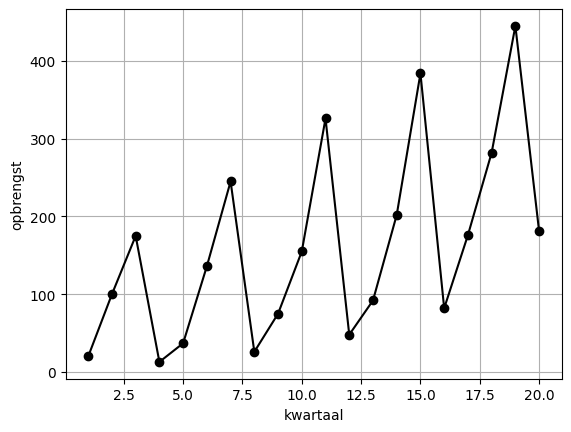

In [105]:
ts = np.array([20, 100, 175, 13, 37, 136, 245, 26, 75, 155, 326, 48, 92, 202, 384, 82, 176, 282, 445, 181])
n = len(ts)
print("lengte tijdreeks:", n)
kwartaal = np.arange(1, n + 1)

plt.plot(kwartaal, ts, 'ko-');
plt.xlabel('kwartaal');
plt.ylabel('opbrengst');
plt.grid();

Dit is een voorbeeld van een **univariate** tijdreeks, omdat er slechts 1 tijdsafhankelijke variabele is, nl. de opbrengst. De tijd - in dit geval de kwartalen - is de onafhankelijke variabele. De bedoeling is nu om die reeks te fitten om dan zo de toekomstige kwartalen te kunnen voorspellen.

### Sliding window method

Om dit met een neuraal netwerk te kunnen doen, moeten we het forecasting probleem eerst omzetten naar een supervised learning probleem. M.a.w. we moeten onze tijdreeks omzetten naar een tabel met features en een target. Dat kunnen we doen m.b.v de **sliding window** methode, of kortweg de window methode. We nemen dus een tijdsvenster en schuiven dat venster op, startend bij het begin van de tijdreeks, tot het venster het einde van de tijdreeks heeft bereikt.

Concreet nemen we de eerste `m` datapunten in de tijdreeks. Van die `m` datapunten doen de eerste `m-1` datapunten dienst als features. Dit is de dimensie van de tijdstappen of time steps in het Engels. Het laatste datapunt is de target. Zo krijgen we de eerste sample in onze dataset. De tweede sample krijgen we door het venster van `m` datapunten 1 tijdstap op te schuiven. Zo gaan we verder tot we aan de laatste sample komen die uit de laatste `m` datapunten van de tijdreeks bestaat.

De techniek wordt op de figuur geïllustreerd voor onze tijdreeks met lengte `n = 20` en voor een venstergrootte van `m = 8`. In dat geval krijgen we 13 samples. De algemene formule voor het aantal samples is `n - m + 1`. Dat wil zeggen dat we uiteindelijk een matrix `X` met features krijgen van 13 rijen en 7 kolommen, en een vector `y` met 13 targets.

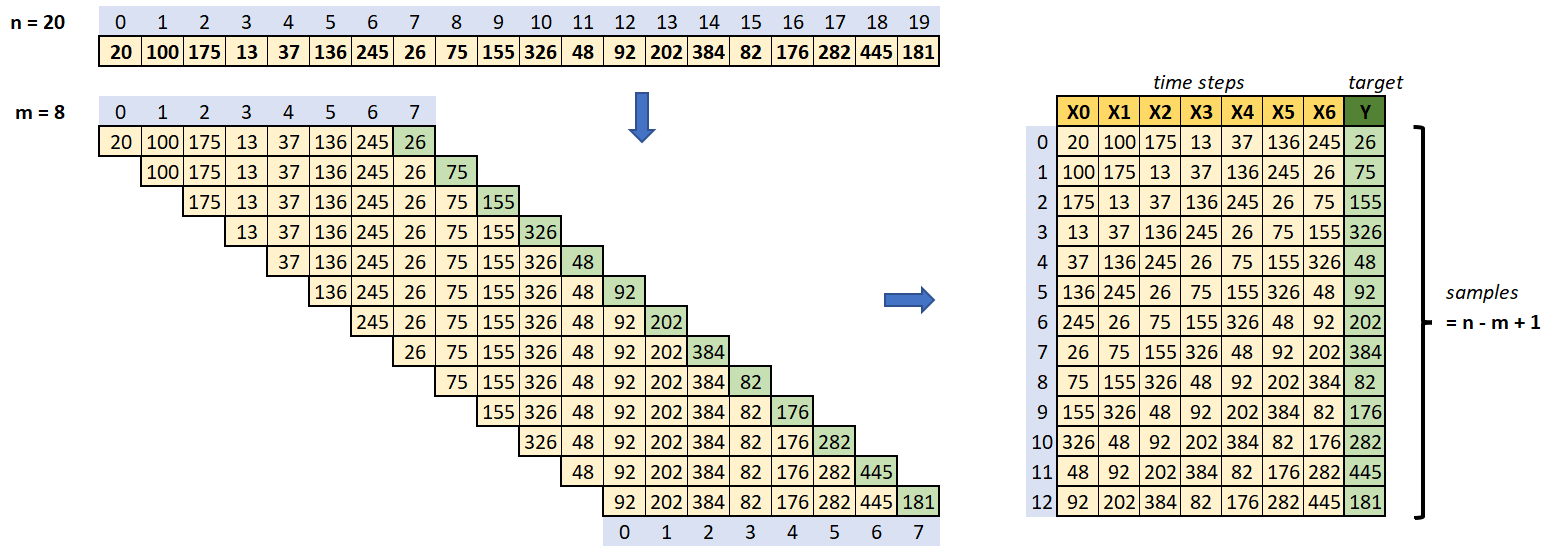

Laten we dat nu eens coderen:

In [106]:
n = len(ts)  # lengte tijdreeks
m = 8  # venstergrootte
k = n - m + 1  # aantal samples
idx = np.arange(m)  # de relatieve indices
table = np.array([ts[i + idx] for i in range(k)])  # we nemen eerst de time steps en targets samen
print(table)

[[ 20 100 175  13  37 136 245  26]
 [100 175  13  37 136 245  26  75]
 [175  13  37 136 245  26  75 155]
 [ 13  37 136 245  26  75 155 326]
 [ 37 136 245  26  75 155 326  48]
 [136 245  26  75 155 326  48  92]
 [245  26  75 155 326  48  92 202]
 [ 26  75 155 326  48  92 202 384]
 [ 75 155 326  48  92 202 384  82]
 [155 326  48  92 202 384  82 176]
 [326  48  92 202 384  82 176 282]
 [ 48  92 202 384  82 176 282 445]
 [ 92 202 384  82 176 282 445 181]]


We krijgen dezelfde tabel als op de figuur, dus dat ziet er ok uit! We weten ondertussen ook al dat we de features en targets best herschalen voor we die aan een neuraal netwerk presenteren. En uiteraard moeten we de tabel nog opsplitsen in een matrix `X` met features en een vector `y` met targets:

In [107]:
X = (table - ts.min()) / (ts.max() - ts.min())  # herschalen
X, y = X[:, :-1], X[:, -1]  # tabel opsplitsen in X en y

Ter illustratie visualiseren we nog eens het principe van de "sliding window" methode adhv een dynamische plot. Terwijl checken we ook of onze tijdreeks correct is omgezet naar features en targets:

In [108]:
from time import sleep
from IPython.display import clear_output

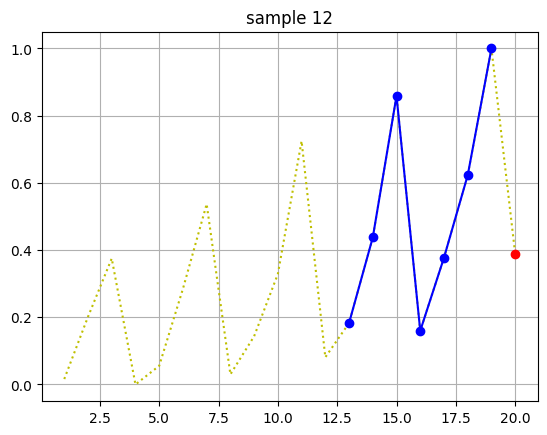

In [109]:
idx = np.arange(1, m + 1)  # relatieve indices van het venster
ts_norm = (ts - ts.min()) / (ts.max() - ts.min())  # herschaalde tijdreeks
for j, (steps, target) in enumerate(zip(X.squeeze(), y.squeeze())):
    clear_output()
    plt.plot(kwartaal, ts_norm, 'y:')
    plt.plot(j + idx[:-1], steps, 'bo-');
    plt.plot(j + idx[-1], target, 'ro');
    plt.title(f"sample {j}")
    plt.grid();
    plt.show()
    sleep(2)

We zien duidelijk dat het venster telkens 1 tijdstap opschuift. We zien ook dat het venster altijd uit 7 blauwe punten bestaat, de features, en op het einde uit 1 rood punt, de target. In totaal schuift het venster 12 keer op en krijgen we dus 13 samples, genummerd van 0 t.e.m. 12. We zien ook dat de data herschaald zijn naar waarden tussen 0 en 1.

Natuurlijk voorziet Keras functies om eenvoudig een tijdreeks om te zetten met de sliding window methode naar geschikte input voor een recurrent neuraal netwerk. Hier in ons voorbeeld kunnen we gebruik maken van de `TimeseriesGenerator`:

In [110]:
from keras.preprocessing import timeseries_dataset_from_array

generator = timeseries_dataset_from_array(
    data=ts, # de tijdreeks
    targets=ts,  # de targets zitten in de tijdreeks...
    sequence_length=m-1,  # lengte van het venster (maar hier zonder de targets)
    batch_size=n-m+1,  # we stoppen de volledige dataset in één batch (= full batch)
)

De gecreëerde generator kunnen we doorlopen met een `for`-lus. In dit geval is er maar 1 batch, dus is er ook maar 1 iteratie:

In [111]:
for samples, targets in generator:
    print(samples.shape)
    print(targets.shape)

(13, 7)
(13,)
(1, 7)
(1,)


Als we `samples` en `targets` concateneren, dan krijgen we dezelfde matrix als matrix `table` die we hierboven zelf hebben gecreëerd adhv de window methode:

In [112]:
np.all(np.hstack((samples, targets[:, np.newaxis])) == table)

False

### Vanilla LSTM

Laten we onze tijdreeks nu eens fitten m.b.v. een **Long Short-Term Memory** (LSTM) model. Hierboven hebben we gezien hoe dit model werkt, en in hoofdstuk 10 van het handboek wordt daar nog dieper op ingegaan.

We passen hier simpelweg een Vanilla LSTM toe; dit is een LSTM model met slechts één LSTM layer en een Dense layer als outputlaag. Uiteraard is onze dataset veel te klein om een performant model op te trainen, want de 20 datapunten kunnen makkelijk "van buiten" geleerd worden. Maar deze oefening is enkel bedoeld als kennismaking met LSTM.

In [113]:
from tensorflow import keras
from keras import layers

In [143]:
model = keras.Sequential(name="Vanilla_LSTM")
model.add(layers.LSTM(2, input_shape=(m-1, 1), name="LSTM"))  # slechts 2 eenheden
model.add(layers.Dense(1, name="Dense"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Vanilla_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                          │ (None, 2)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

Dit is dus een heel eenvoudig netwerk met 1 LSTM laag met slechts 2 nodes en een Dense laag met 1 node. Toch krijgen we al 35 trainable parameters. Bemerk dat er geen activatiefunctie wordt opgegeven. 'Inwendig' past de LSTM laag de sigmoïdefunctie `"sigmoid"` en de tangenshyperbolicus functie `"tanh"` toe. Maar je kan ook nog een activatiefunctie definiëren voor de output van de laag, zoals `"relu"`. De default is hier echter ook de `"tanh"` functie. De Dense layer heeft geen activatiefunctie (en dat is ook de default!).

Eén belangrijk aspect hier is de **input shape** van het model, die rechtstreeks wordt meegegeven aan de LSTM laag. We hebben 13 samples die bestaan uit 7 tijdstappen. Dus matrix `X` heeft een shape van `(13, 7)`. Herinner je dat de eerste dimensie de samples weergeeft en dus weergegeven wordt met `None`. De tweede dimensie bij tijdreeksen zijn de time steps. Maar dan is er nog een derde dimensie met de features. Hiermee bedoelt men het aantal tijdafhankelijke variabelen. Hier hebben we te maken met een univariate reeks, dus hebben we slechts één feature, nl. de opbrengst. Vandaar dat de input shape `(7, 1)` moet zijn en dat `X` driedimensionaal moet worden met shape gelijk aan `(13, 7, 1)`. Straks zien we een voorbeeld van een multivariate reeks, en dan zal die laatste dimensie groter zijn dan 1, omdat de dataset dan een tijdreeks is met meerdere variabelen of features.

In [115]:
X = X[:, :, np.newaxis]  # singleton dimensie toevoegen
X.shape

(13, 7, 1)

We compileren het model en gebruiken RMSprop als optimizer. Net als bij regressieproblemen nemen we de MSE als lossfunctie en de MAE als evaluatiemetriek omdat die laatste dezelfde eenheid heeft als de data.

In [145]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
    loss="mse",
    metrics=["mae"]
)

We zijn nu klaar om het model te trainen. We geven dus `X` en `y` door zoals bij een traditioneel feedfoward netwerk. We nemen 500 epochs zodat we zeker een goeie fit hebben.

In [147]:
history = model.fit(X, y, epochs=500)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 13
'y' sizes: 500


We evalueren het model adhv de trainingset (omdat we geen testset hebben):

In [118]:
mse, mae = model.evaluate(X, y)
print("mse:", mse)
print("mae:", mae)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0010 - mae: 0.0265
mse: 0.0010151044698432088
mae: 0.026529911905527115


We krijgen een (bijna) perfecte fit, wat we ook zien als we de loss plotten:

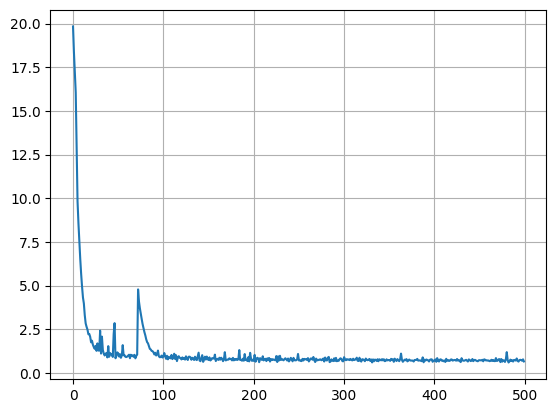

In [155]:
plt.plot(history.history['loss']);
plt.grid();

### Forecasting

We kunnen nu de reeks met "voorspellingen" opvragen door methode `predict` toe te passen op matrix `X`:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


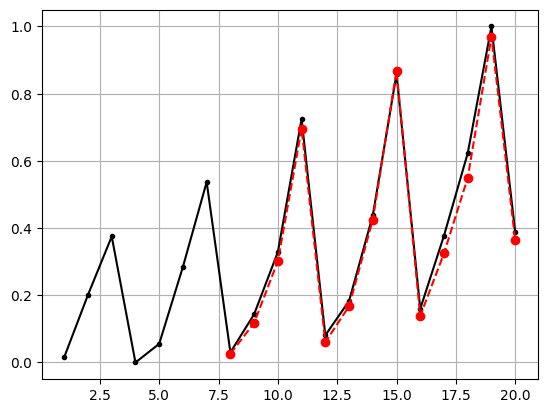

In [120]:
yp = model.predict(X)  # voorspelde tijdreeks
ts_norm = (ts - ts.min()) / (ts.max() - ts.min())  # herschaalde tijdreeks
plt.plot(kwartaal, ts_norm, 'k.-')
plt.plot(range(m, n+1), yp.squeeze(), 'ro--');
plt.grid();

Merk op dat de voorspellingen starten bij `m` omdat dit de grootte van ons venster is! Maar hoe maken we nu échte voorspellingen in de toekomst met dit model? Er zijn verschillende mogelijkheden, waarvan de eenvoudigste methode is om recursief de voorspelde waarde toe te voegen aan matrix `X`. Dit noemen we een **Recursive Multi-step Forecast Strategy**.

We starten de recursie door de voorspelling `yp` aan de reeks toe te voegen en de sliding window techniek toe te passen op de nieuwe reeks, waarbij we het eerste datapunt schrappen. Dit wordt hieronder afgebeeld op de figuur:

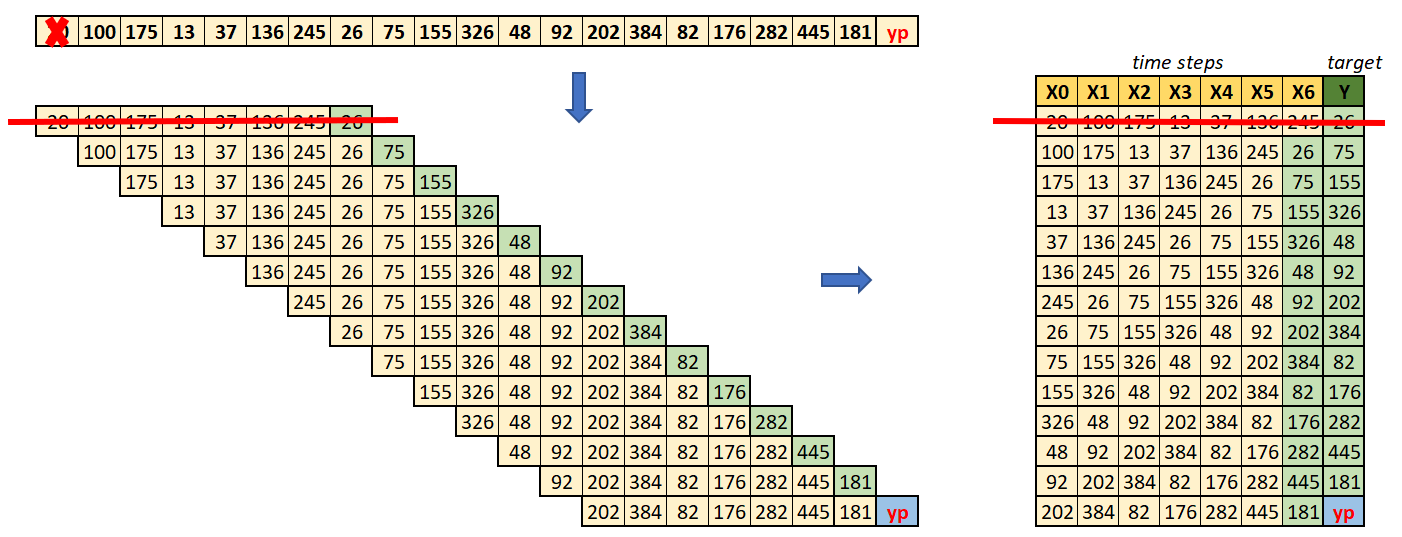

Dit kunnen we eenvoudig coderen door `y` achteraan toe te voegen aan matrix `X` en de eerste kolom te verwijderen uit `X`. De nieuwe matrix met features noemen we `Xnew`:

In [121]:
Xnew = np.zeros(X.shape)  # initialiseren
Xnew[:, :-1, 0] = X[:, 1:, 0]  # alle kolommen toevoegen uitgezonderd de eerste
Xnew[:, -1, 0] = y  # y toevoegen als laatste kolom

We kunnen nu een nieuwe reeks voorspellen obv `Xnew`. Het laatste element van die nieuwe reeks zal de eerste echte forecast bevatten die één tijdstap later is dan het einde van de tijdreeks. Op de figuur hierboven is dat de variabele `yp`. In de code noemen we de nieuwe voorspelde reeks `ypnew`:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


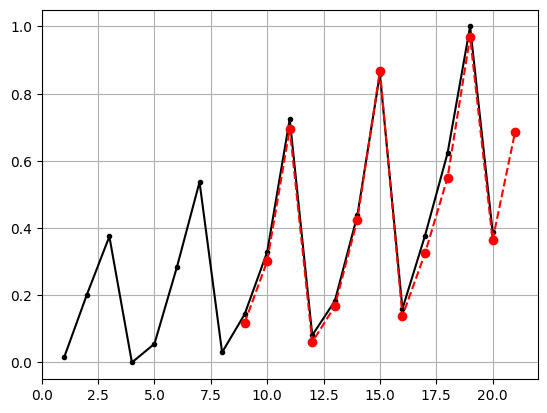

In [122]:
ypnew = model.predict(Xnew)  # nieuwe reeks voorspellen
plt.plot(kwartaal, ts_norm, 'k.-')
plt.plot(range(m+1, n+2), ypnew.squeeze(), 'ro--');
plt.grid();

Pas op! Stel dat we gewoon `y` toevoegen aan `X` zonder de eerste kolom te verwijderen, dan krijgen we een vreemd resultaat... In dat geval bevat `X` 8 ipv 7 kolommen, en toch geeft Keras geen foutmelding!

In [123]:
Xwrong = np.concatenate((X, np.reshape(y, [-1, 1, 1])), axis=1)
Xwrong.shape

(13, 8, 1)

In [124]:
ypwrong = model.predict(Xwrong)  # nieuwe reeks voorspellen
ypwrong.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


(13, 1)

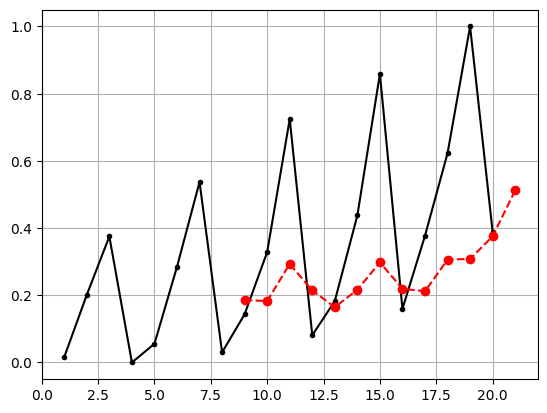

In [125]:
plt.plot(kwartaal, ts_norm, 'k.-')
plt.plot(range(m+1, n+2), ypwrong.squeeze(), 'ro--');
plt.grid();

We kunnen nu de recursie verder zetten door opnieuw de eerste kolom uit `Xnew` verwijderen en `ypnew` achteraan toevoegen. Maar dat is niet zo'n goed idee, want `ypnew` bevat voorspellingen voor tijdstappen waarvan we de echte waarden kennen. Dus we mogen enkel het laatste element van `ypnew` aan de matrix met features toevoegen, zoals op de figuur hieronder staat afgebeeld:

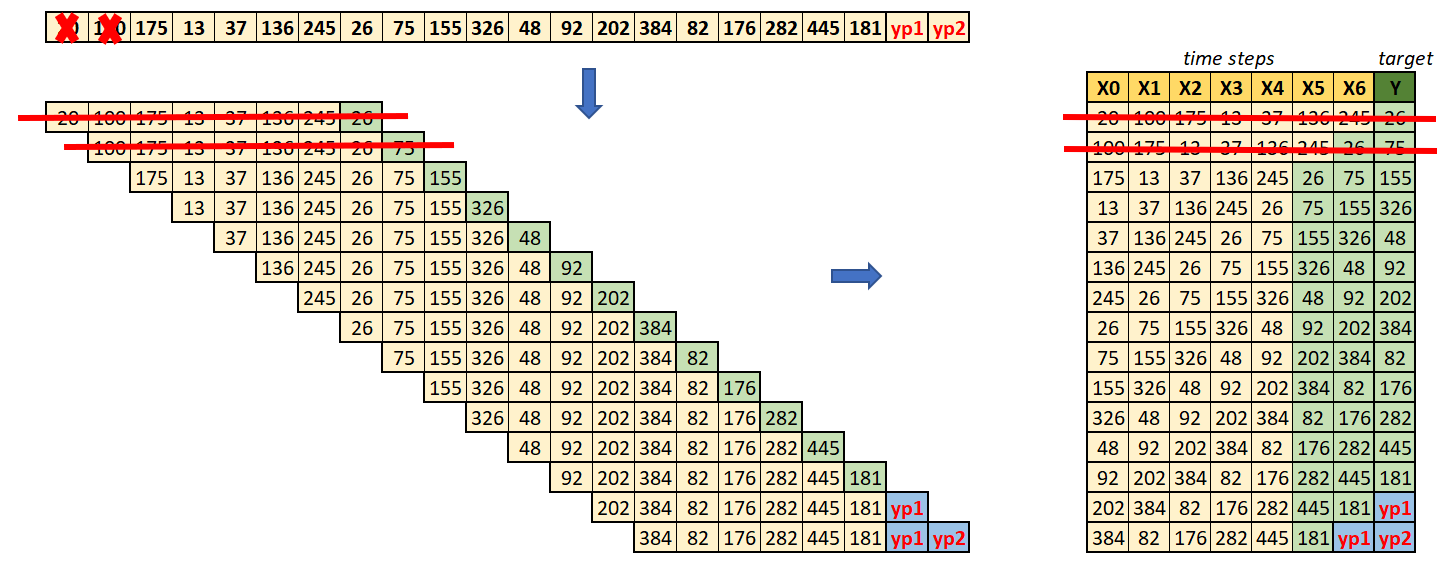

We kunnen deze recursieve procedure veralgemenen door gebruik te maken van een `for`-loop. Laten we de volgende 8 kwartalen eens forecasten:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<ipython-input-126-6e4f59579bca>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Xnew[-1, -1, 0] = yp[-1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


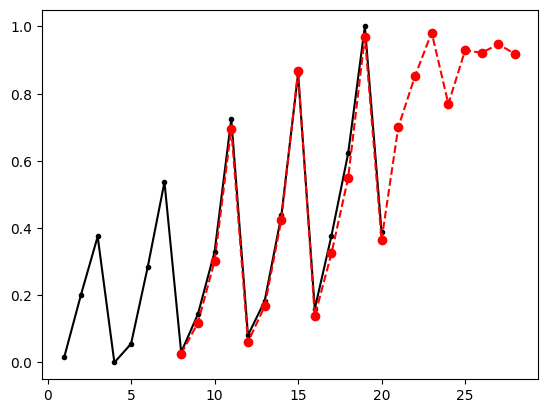

In [126]:
k = 8  # aantal forecasts
yp = model.predict(X)
Xold = X.copy()
for i in range(1, k + 1):
    Xnew = np.zeros(Xold.shape)
    Xnew[:, :-1, 0] = Xold[:, 1:, 0]
    Xnew[:-1, -1, 0] = Xold[1:, -1, 0]
    Xnew[-1, -1, 0] = yp[-1]
    yp = np.append(yp, model.predict(Xnew)[-1])
    Xold = Xnew.copy()
plt.plot(kwartaal, ts_norm, 'k.-')
plt.plot(range(m, n + k + 1), yp.squeeze(), 'ro--');

De eerste 4 kwartalen volgen nog het seizoenale patroon, maar vanaf dan niet meer. Dat is omdat we steeds meer voorspellingen gebruiken om een nieuwe forecast te berekenen naarmate we verder gaan in de toekomst. Om dat te voorkomen kunnen we andere methoden toepassen:

- *Direct Multi-step Forecast Strategy*: voor elke tijdstap die we willen voorspellen wordt een nieuw model getraind, zonder rekening te houden met de modellen van de voorgaande tijdstappen;
- *Direct-Recursive Hybrid Multi-step Forecast Strategy*: een combinatie van de directe en de recursieve strategie waarbij ook voor elke tijdstap waarop we een voorspelling willen een nieuw model wordt getraind, maar waarbij de voorspellingen van de vorige modellen worden toegevoegd aan de dataset.
- *Multiple Output Forecast Strategy*: er wordt slechts één model getraind dat alle te voorspellen tijdstappen als output heeft.

### Multivariate tijdreeks

We breiden de dataset uit met een tweede tijdreeks die de inkomsten van het fictieve bedrijf bevat. We genereren die tijdreeks door de helft van de opbrengsten te vermeerderen met 10 en er normaalverdeelde ruis op te steken met gemiddelde 0 en standaardafwijking 10:

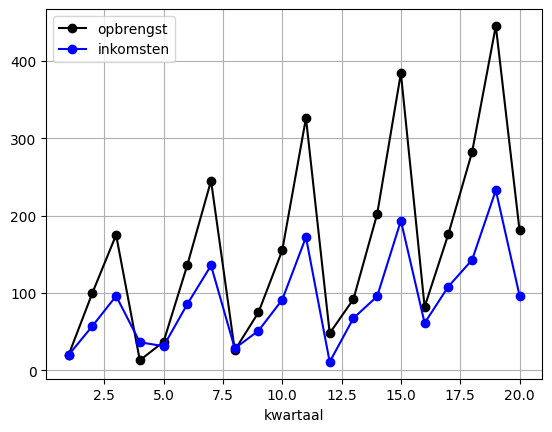

In [127]:
# tijdreeks met opbrengsten
ts = np.array([20, 100, 175, 13, 37, 136, 245, 26, 75, 155, 326, 48, 92, 202, 384, 82, 176, 282, 445, 181])
n = len(ts)

# tijdreeks met inkomsten
np.random.seed(2022)
ts2 = 10 + 0.5 * ts + np.random.randn(n) * 10

# plot
kwartaal = np.arange(1, n + 1)
plt.plot(kwartaal, ts, 'ko-', kwartaal, ts2, 'bo-');
plt.xlabel('kwartaal');
plt.grid();
plt.legend(["opbrengst", "inkomsten"]);

We hebben nu twee tijdsafhankelijke variabelen, nl. de opbrengsten (zwart) en de inkomsten (blauw). Daarom spreken we van een bivariate tijdreeks. Of algemeen van een **multivariate tijdreeks**.

De bedoeling is om net als bij de univariate reeks de opbrengsten te voorspellen, maar nu hebben we dus 2 features, nl. de opbrengsten én de inkomsten uit het verleden.

We gaan opnieuw de window methode toepassen en maken deze keer wel gebruik van Keras utility `TimeseriesGenerator`. Uiteraard moeten we de reeksen eerst herschalen. Daarna stoppen we de reeksen in de kolommen van matrix `data`:

In [130]:
ts_norm = (ts - ts.min()) / (ts.max() - ts.min())
ts2_norm = (ts2 - ts2.min()) / (ts2.max() - ts2.min())
data = np.array([ts_norm, ts2_norm]).T

generator = timeseries_dataset_from_array(
    data=data,  # de tijdreeksen (als kolommen in matrix data!)
    targets=ts_norm,  # de targets zitten in de tijdreeks met opbrengsten!
    sequence_length=m-1,  # lengte van het venster (maar hier zonder de targets)
    batch_size=n-m+1,  # we stoppen de volledige dataset in één batch (= full batch)
)

We checken de shape van de batch matrix en de target vector:

In [131]:
for samples, targets in generator:
    print(samples.shape)
    print(targets.shape)

(13, 7, 2)
(13,)
(1, 7, 2)
(1,)


We zien dat deze keer matrix `samples` inderdaad een derde dimensie heeft met een lengte gelijk aan het aantal tijdreeksen! Herinner je de volgende figuur uit het hoofdstuk over Tensoren waarin werd uitgelegd hoe een dataset met tijdreeksen is opgebouwd. Het aantal samples is hier dus gelijk aan 13, het aantal time steps gelijk aan 7, en het aantal features gelijk aan 2.

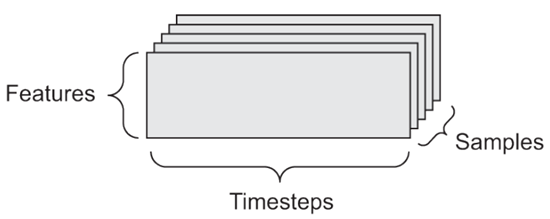

Ter controle visualiseren we de samples en targets mbv een dynamische plot:

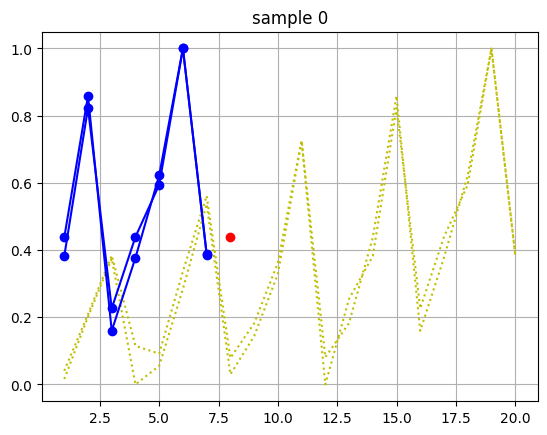

In [132]:
idx = np.arange(1, m + 1)  # relatieve indices van het venster
for j, (sample, target) in enumerate(zip(samples, targets)):
    clear_output()
    plt.plot(kwartaal, data, 'y:')
    plt.plot(j + idx[:-1], sample, 'bo-');
    plt.plot(j + idx[-1], target, 'ro');
    plt.title(f"sample {j}")
    plt.grid();
    plt.show()
    sleep(2)

Dat ziet er correct uit! We zien telkens maar 1 rode stip omdat we natuurlijk maar 1 target hebben per sample, nl. de opbrengst. De inkomsten voorspellen we niet (maar dat zouden we natuurlijk wel kunnen als we 2 outputs definiëren in ons model).

### Stacked LSTM

Deze keer gaan we een tweede LSTM laag toevoegen aan het model. De `input_shape` is nu dus `(m-1, 2)` omdat we 2 tijdreeksen (of features) hebben. We mogen ook niet vergeten om bij de eerste LSTM laag `return_sequences` op `True` te zetten zodat de volledige reeksen kunnen doorgegeven worden aan de volgende LSTM laag. Doen we dan niet, dan krijgen we een foutmelding.

In [135]:
model = keras.Sequential(name="Stacked_LSTM")
model.add(layers.LSTM(2, input_shape=(m-1, 2), name="LSTM1", return_sequences=True))
model.add(layers.LSTM(2, name="LSTM2"))
model.add(layers.Dense(1, name="Dense"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Stacked_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM1 (LSTM)                         │ (None, 7, 2)                │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM2 (LSTM)                         │ (None, 2)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83 (332.00 B)

 Trainable params: 83 (332.00 B)

 Non-trainable params: 0 (0.00 B)

We compileren het model en gebruiken dezelfde optimizer, lossfunctie en evaluatiemetriek als in het vorige model:

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
    loss="mse",
    metrics=["mae"]
)

We kunnen nu het model trainen. Deze keer moeten we de `generator` doorgeven aan de `fit` methode. Omdat we meer data hebben nemen we voor de zekerheid 1000 epochs:

In [ ]:
history = model.fit(generator, epochs=1000)

We evalueren het model adhv de trainingset (omdat we geen testset hebben):

In [ ]:
mse, mae = model.evaluate(generator)
print("mse:", mse)
print("mae:", mae)

We krijgen opnieuw een uitstekende fit, wat we ook zien als we de loss plotten:

In [ ]:
plt.plot(history.history['loss']);
plt.grid();

Tot slot plotten we de voorspellingen samen met de echte data. We zien dat die zeer goed overeenkomen:

In [ ]:
yp = model.predict(generator)  # voorspelde tijdreeks
plt.plot(kwartaal, ts_norm, 'k.-')
plt.plot(range(m, n+1), yp.squeeze(), 'ro--');
plt.grid();

Uiteraard kunnen we hier opnieuw voorspellingen in de toekomst maken, maar omdat we nu met twee tijdsafhankelijke variabelen zitten en de inkomsten niet mee voorspellen, hebben we iets minder mogelijkheden als bij de univariate tijdreeks. Ga zelf eens na welke strategieën mogelijk zijn en welke niet!

Nu we kennis hebben gemaakt met RNNs, kunnen we aan het echte werk beginnen en de codevoorbeelden uit het handboek doorlopen. Maar eerst kan je de opgedane kennis al eens uittesten op de dataset van de maandelijkse melkproductie.

## Oefeningen

### Oefening 1

Train een "Vanilla LSTM" neuraal netwerk die de volgende wiskundige functie fit:

> `y = 1 + 0.02 * x + sin(x)`

Genereer 500 datapunten in het interval `[0, 100 * pi]`. Neem de MSE als lossfunctie en de MAE als evaluatiemetriek.

Probeer uiteraard om een zo goed mogelijke fit te krijgen, maar hou het LSTM model wel zo klein mogelijk! D.w.z. probeer een model op te stellen met zo weinig mogelijk parameters!


((500,), (500,))

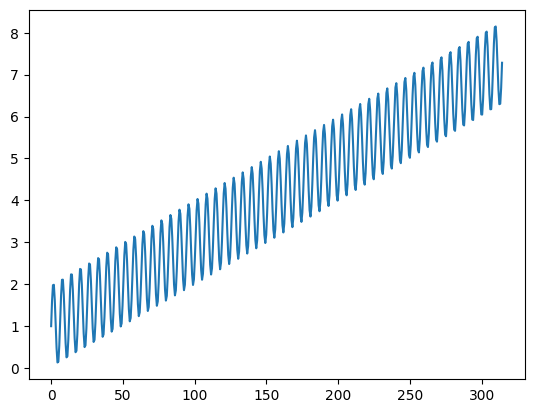

In [150]:
num_points = 500
interval = (0, 100 * np.pi)
x = np.linspace(interval[0], interval[1], num_points)
y = 1 + 0.02 * x + np.sin(x)
plt.plot(x, y)
x.shape, y.shape

In [151]:
x = x[:, np.newaxis]
x_train =

In [152]:
model = keras.Sequential(name="Vanilla_LSTM")
model.add(layers.LSTM(2, input_shape=(m-1, 1), name="LSTM"))  # slechts 2 eenheden
model.add(layers.Dense(1, name="Dense"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Vanilla_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                          │ (None, 2)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

In [153]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.01),
    loss="mse",
    metrics=["mae"]
)

In [154]:
history = model.fit(x, y, epochs=500)

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.8499 - mae: 4.0292
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9127 - mae: 3.7696  
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6486 - mae: 3.7095 
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.8041 - mae: 3.4792 
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.3518 - mae: 3.2687 
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8786 - mae: 2.6675 
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8607 - mae: 2.4646 
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1093 - mae: 2.3729 
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4422 - mae: 2.0390 
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5562 - mae: 1.8862 
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8560 - mae: 1.7818 
Epoch 12/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4998 - mae: 1.7435 
Epoch 13/500
16/16 ━

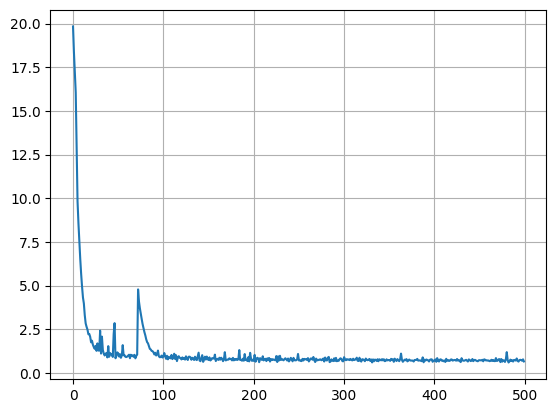

In [156]:
plt.plot(history.history['loss']);
plt.grid();

### Oefening 2

Lees de file `"monthly_milk_production.csv"` in als Pandas `DataFrame`. De file bevat de maandelijkse productiecijfers van een melkveebedrijf. Verken het dataframe en maak een plot van de tijdreeks. Stel een `TimeseriesGenerator` object op zodat de tijdreeks kan gebruikt worden als input voor een RNN. Denk na over de lengte van het venster.

Stel een LSTM op en probeer de tijdreeks zo goed mogelijk te fitten. Kijk nog niet naar overfitting. Varieer het aantal lagen en het aantal units per laag. Probeer ook eens uit wat het effect is als je een andere activatiefunctie definieert voor de LSTM lagen, zoals de `"relu"` functie. Bij tijdreeksen wordt ook dikwijls de ADAM solver gebruikt ipv de RMSprop. Probeer die ook eens uit en wijzig de learning rate, de lengte van het venster, de batch size en het aantal epochs. Gebruik de MSE als lossfunctie en de MAPE als metriek. Pas op! In Keras wordt de MAPE als percentage uitgedrukt (d.i. een getal tussen 0 en 100)!

Eens je een performant model hebt, bereken dan de voorspellingen voor de volgende 12 maanden. Denk na hoe je best te werk gaat gebruik makend van de `TimeseriesGenerator`. Schrijf generieke code!

---
## Bronnen

- Chollet, F. (2021) Deep Learning with Python, Second Edition, Manning, Shelter Island, NY.
- https://en.wikipedia.org/wiki/Long_short-term_memory
- https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://machinelearningmastery.com/multi-step-time-series-forecasting/
- https://www.section.io/engineering-education/univariate-time-series-using-recurrent-neural-networks/

---